In [183]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import matplotlib.pyplot as plt
import sys
import torch
from neutromeratio.parameter_gradients import FreeEnergyCalculator
from neutromeratio.constants import kT, device

path = 'neutromeratio_results_nov15/SAMPLmol2/'
from glob import glob

dcds = glob(path + '*.dcd')

In [184]:
# read in exp results, smiles and names
exp_results = pickle.load(open('/Users/joshuafass/Documents/Github/neutromeratio/data/exp_results.pickle', 'rb'))

exclude = ['molDWRow_1004', 'molDWRow_1110', 'molDWRow_1184', 'molDWRow_1185', 'molDWRow_1189', 'molDWRow_1262', 'molDWRow_1263',
'molDWRow_1267', 'molDWRow_1275', 'molDWRow_1279', 'molDWRow_1280', 'molDWRow_1282', 'molDWRow_1283', 'molDWRow_553',
'molDWRow_557', 'molDWRow_580', 'molDWRow_581', 'molDWRow_582', 'molDWRow_615', 'molDWRow_616', 'molDWRow_617',
'molDWRow_618', 'molDWRow_643', 'molDWRow_758', 'molDWRow_82', 'molDWRow_83', 'molDWRow_952', 'molDWRow_953',
'molDWRow_955', 'molDWRow_988', 'molDWRow_989', 'molDWRow_990', 'molDWRow_991', 'molDWRow_992']

# name of the system
protocoll = []
for name in sorted(exp_results):
    if name in exclude:
        continue
    protocoll.append(name)
idx = 1
name = protocoll[idx-1]
print(name)

SAMPLmol2


[tautomers.py:370 - _perform_tautomer_transformation()] Index of atom that moves: 11.
[tautomers.py:382 - _perform_tautomer_transformation()] Index of atom that donates hydrogen: 0
[tautomers.py:400 - _perform_tautomer_transformation()] Index of atom that accepts hydrogen: 10


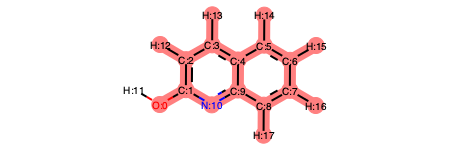

[tautomers.py:114 - add_droplet()] Adding droplet ...


Adding restraint to center to 19
Adding restraint to center to 22
Adding restraint to center to 25
Adding restraint to center to 28
Adding restraint to center to 31
Adding restraint to center to 34
Adding restraint to center to 37
Adding restraint to center to 40
Adding restraint to center to 43
Adding restraint to center to 46
Adding restraint to center to 49
Adding restraint to center to 52
Adding restraint to center to 55
Adding restraint to center to 58
Adding restraint to center to 61
Adding restraint to center to 64
Adding restraint to center to 67
Adding restraint to center to 70
Adding restraint to center to 73
Adding restraint to center to 76
Adding restraint to center to 79
Adding restraint to center to 82
Adding restraint to center to 85
Adding restraint to center to 88
Adding restraint to center to 91
Adding restraint to center to 94
Adding restraint to center to 97
Adding restraint to center to 100
Adding restraint to center to 103
Adding restraint to center to 106
Adding 

[restraints.py:180 - __init__()] Center Of Mass restraint added.


In [185]:
def prepare(name, mode="forward"):

    diameter_in_angstrom = 18
    base_path = path

    # don't change - direction is fixed for all runs
    #################
    t1_smiles = exp_results[name]['t1-smiles']
    t2_smiles = exp_results[name]['t2-smiles']


    # generate both rdkit mol
    tautomer = neutromeratio.Tautomer(name=name, intial_state_mol=neutromeratio.generate_rdkit_mol(t1_smiles), final_state_mol=neutromeratio.generate_rdkit_mol(t2_smiles), nr_of_conformations=20)
    if mode == 'forward':
        tautomer.perform_tautomer_transformation_forward()
    elif mode == 'reverse':
        tautomer.perform_tautomer_transformation_reverse()
    else:
        raise RuntimeError('No tautomer reaction direction was specified.')

    tautomer.add_droplet(tautomer.hybrid_topology, 
                                tautomer.hybrid_coords, 
                                diameter=diameter_in_angstrom * unit.angstrom,
                                restrain_hydrogens=True,
                                file=f"{base_path}/{name}_in_droplet_{mode}.pdb")

    # define the alchemical atoms
    alchemical_atoms=[tautomer.hybrid_dummy_hydrogen, tautomer.hydrogen_idx]

    print('Nr of atoms: {}'.format(len(tautomer.ligand_in_water_atoms)))

    # extract hydrogen donor idx and hydrogen idx for from_mol
    model = neutromeratio.ani.LinearAlchemicalDualTopologyANI(alchemical_atoms=alchemical_atoms)
    model = model.to(device)
    torch.set_num_threads(2)

    # perform initial sampling
    energy_function = neutromeratio.ANI1_force_and_energy(
                                            model = model,
                                            atoms = tautomer.ligand_in_water_atoms,
                                            mol = None,
                                            )

    tautomer.add_COM_for_hybrid_ligand(np.array([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2]) * unit.angstrom)

    for r in tautomer.ligand_restraints:
        energy_function.add_restraint(r)

    for r in tautomer.hybrid_ligand_restraints:
        energy_function.add_restraint(r)

    for r in tautomer.solvent_restraints:
        energy_function.add_restraint(r)

    for r in tautomer.com_restraints:
        energy_function.add_restraint(r)
    return model, tautomer, energy_function
model, tautomer, energy_function = prepare(name)

In [186]:
lam_str = '0.0000' 
dcd = [d for d in dcds if lam_str in d][0]
dcd

'neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.0000_in_droplet_forward.dcd'

In [187]:
csvs = glob(path + '*.csv')
csv = [c for c in csvs if lam_str + '_energy' in c][0]
csv

'neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.0000_energy_in_droplet_forward.csv'

In [188]:
import pandas as pd


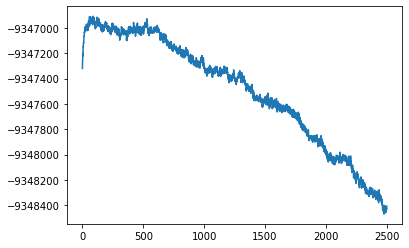

In [189]:
plt.plot(pd.read_csv(csv))

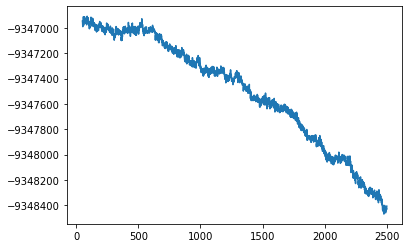

In [190]:
plt.plot(pd.read_csv(csv)[50:])

In [191]:
def parse_lambda_from_filename(filename):
    return float(filename[:filename.find('_in_droplet')].split('_')[-1])


In [192]:
dcd, parse_lambda_from_filename(dcd)

('neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.0000_in_droplet_forward.dcd',
 0.0)

In [193]:
traj = md.load_dcd(dcd, top=tautomer.ligand_in_water_topology)

In [194]:
traj.superpose(traj[-1])

<mdtraj.Trajectory with 2501 frames, 349 atoms, 111 residues, without unitcells at 0x1308defd0>

In [195]:
all_atoms = np.arange(traj.n_atoms)
all_atoms

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [196]:
dummy_atom_0 = model.alchemical_atoms[0]
dummy_atom_0

18

In [200]:
atoms_without_dummy = np.hstack((np.arange(0,dummy_atom_0), np.arange(dummy_atom_0+1, traj.n_atoms)))

In [ ]:
(coordinates[:, :dummy_atom_0],  coordinates[:, dummy_atom_0+1:]), dim=1) 

In [201]:
traj_without_dummy = traj.atom_slice(atoms_without_dummy)

In [202]:
traj_without_dummy.superpose(traj_without_dummy[-1])

<mdtraj.Trajectory with 2501 frames, 348 atoms, 111 residues, without unitcells at 0x133b719b0>

In [203]:
name

'SAMPLmol2'

In [205]:
traj_without_dummy.save_hdf5('{}_lambda={}.h5'.format(name, lam_str))

In [207]:
import mdtraj as md
all_residues = list(traj_without_dummy.top.residues)
water_residues = all_residues[1:]
angle_indices = []

for i, residue in enumerate(water_residues):
    O,H1,H2 = [a.index for a in residue.atoms]
    angle_indices.append((H1,O,H2))
angle_indices = np.array(angle_indices)
angles = md.compute_angles(traj_without_dummy, angle_indices=angle_indices)
angles.shape

(2501, 110)

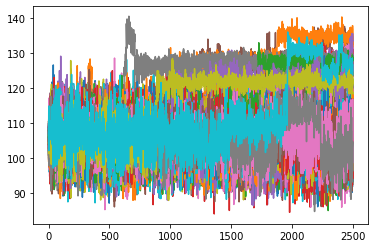

In [209]:
plt.plot(angles * 180 / np.pi);

In [206]:
traj_without_dummy[-10:].save_pdb('quick_look.pdb')

In [12]:
xyz_in_angstroms = traj.xyz[::10] * 10

In [13]:
xyz_in_angstroms.shape

(251, 349, 3)

In [14]:
species = energy_function.species
species.shape

torch.Size([1, 349])

In [15]:
dummy_atom_0 = model.alchemical_atoms[0]
dummy_atom_0

18

In [16]:
coordinates = torch.tensor(xyz_in_angstroms)
n_snapshots = len(coordinates)
coordinates.shape

torch.Size([251, 349, 3])

In [17]:
species = torch.stack([energy_function.species[0]] * n_snapshots)
species.shape

torch.Size([251, 349])

In [18]:
mod_species_0 = torch.cat((species[:, :dummy_atom_0],  species[:, dummy_atom_0+1:]), dim=1)
mod_coordinates_0 = torch.cat((coordinates[:, :dummy_atom_0],  coordinates[:, dummy_atom_0+1:]), dim=1) 
_, mod_aevs_0 = model.aev_computer((mod_species_0, mod_coordinates_0))

In [19]:
traj.n_atoms

349

In [20]:
n_snapshots = len(coordinates)
n_atoms = len(coordinates[0] - 1)
n_models = energy_function.model.ensemble_size
n_snapshots, n_atoms, n_models

(251, 349, 8)

In [21]:
len(energy_function.species.flatten())

349

In [22]:
mod_species_0.shape, mod_coordinates_0.shape

(torch.Size([251, 348]), torch.Size([251, 348, 3]))

In [23]:
torch.stack([mod_species_0[0]] * len(mod_coordinates_0)).shape

torch.Size([251, 348])

In [26]:
from tqdm import tqdm

In [27]:
def compute_atomic_energy_contributions_without_dummy_atom(traj, model, energy_function, dummy_atom):
    n_models = energy_function.model.ensemble_size
    
    xyz_in_angstroms = traj.xyz * 10
    coordinates = torch.tensor(xyz_in_angstroms)
    n_snapshots = len(coordinates)
    
    species = energy_function.species
    mod_species = torch.cat((species[:, :dummy_atom],  species[:, dummy_atom+1:]), dim=1)
    
    species_list = list(map(int, mod_species[0]))
    n_atoms = len(species_list)
    
    print('n_snapshots: {}, n_atoms: {}, n_models: {}'.format(n_snapshots, n_atoms, n_models))
    
    mod_coordinates = torch.cat((coordinates[:, :dummy_atom],  coordinates[:, dummy_atom+1:]), dim=1)
    mod_species = torch.stack([mod_species[0]] * len(mod_coordinates))
    print('mod_species.shape', mod_species.shape)
    print('mod_coordinates.shape', mod_coordinates.shape)
    _, mod_aevs = model.aev_computer((mod_species, mod_coordinates))
    
    
    raw_energies = np.zeros((n_snapshots, n_atoms, n_models))
    for i in tqdm(range(n_atoms)):
        for j in range(n_models):
            raw_energies[:,i,j] = model.neural_networks[j][species_list[i]].forward(mod_aevs[:,i,:]).detach().flatten()
    return raw_energies

def compute_endstate_atomic_energy_contributions(traj, model, energy_function):
    assert(len(model.alchemical_atoms) == 2)
    
    if len(traj) > 300: print('warning! may want to break traj into bite-size chunks')
    
    dummy_0, dummy_1 = model.alchemical_atoms
    print('(dummy_0, dummy_1)', dummy_0, dummy_1)
    
    raw_energies_without_dummy_0 = compute_atomic_energy_contributions_without_dummy_atom(
        traj, model, energy_function, dummy_0)
    
    raw_energies_without_dummy_1 = compute_atomic_energy_contributions_without_dummy_atom(
        traj, model, energy_function, dummy_1)
    
    return raw_energies_without_dummy_0, raw_energies_without_dummy_1

In [28]:
raw_energies_without_dummy_0, raw_energies_without_dummy_1 = compute_endstate_atomic_energy_contributions(traj[::10], model, energy_function)

(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 69.22it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 78.52it/s]


In [32]:
from neutromeratio.ani import hartree_to_kJ_mol

In [36]:
def compute_total_uncertainties(raw_energies):
    total_uncertainties = (raw_energies * hartree_to_kJ_mol).sum(1).std(-1)
    return total_uncertainties
    
def compute_linear_penalty(raw_energies_0, raw_energies_1,
                           lambda_value, per_atom_thresh=0.5):
    """raw_energies in hartree, per_atom_thresh in kj/mol"""
    total_thresh = per_atom_thresh * n_atoms
    
    total_uncertainties_0 = compute_total_uncertainties(raw_energies_0)
    total_uncertainties_1 = compute_total_uncertainties(raw_energies_1)
    
    total_uncertainties = (1 - lambda_value) * total_uncertainties_0 + lambda_value * total_uncertainties_1
    
    linear_penalty = np.maximum(0, total_uncertainties - total_thresh)
    return linear_penalty

In [37]:
lambda_value = float(lam_str)
lambda_value

0.0

In [39]:
linear_penalty = compute_linear_penalty(raw_energies_without_dummy_0, raw_energies_without_dummy_1, lambda_value)

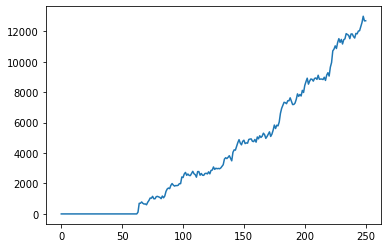

In [40]:
plt.plot(linear_penalty)

In [80]:
def compute_last_valid_ind(linear_penalty):
    last_valid_ind = np.argmax(np.cumsum(linear_penalty) > 0) - 1
    return last_valid_ind
last_valid_ind = compute_last_valid_ind(linear_penalty)

In [53]:
linear_penalty[last_valid_ind]

0.0

In [60]:
from pymbar.timeseries import detectEquilibration
energy_trace = raw_energies_without_dummy_0.mean(-1).sum(1)[:last_valid_ind]

In [65]:
detectEquilibration(energy_trace, fast=False)

(0, 2.016002, 31.24997)

In [66]:
detectEquilibration(energy_trace, fast=True)

(0, 2.2376597, 28.154415)

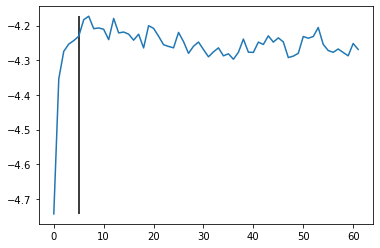

In [67]:
plt.plot(energy_trace)
plt.vlines(5,min(energy_trace),max(energy_trace))

In [69]:
available_snapshots = coordinates[5:last_valid_ind]

In [76]:
from collections import namedtuple
RawEnergies = namedtuple('RawEnergies',
                         ['raw_energies_without_dummy_0',
                          'raw_energies_without_dummy_1'
                         ]
                        )
raw_energy_dict = {}
for dcd in dcds:
    print(dcd)
    lam = parse_lambda_from_filename(dcd)
    traj = md.load_dcd(dcd, top=tautomer.ligand_in_water_topology)
    raw_energies_without_dummy_0, raw_energies_without_dummy_1 = compute_endstate_atomic_energy_contributions(traj[::10], model, energy_function)
    raw_energies = RawEnergies(raw_energies_without_dummy_0, raw_energies_without_dummy_1)
    raw_energy_dict[lam] = raw_energies

neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.0000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 79.62it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 79.27it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.8000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 79.95it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 79.22it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.5500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 68.22it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 80.01it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.2500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 80.94it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 78.58it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.7000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 76.82it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 79.32it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.2000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 71.00it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 62.40it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_1.0000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 58.63it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:09<00:00, 36.55it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.7500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 62.98it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 67.23it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.0500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 59.10it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:08<00:00, 42.36it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.8500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:04<00:00, 72.89it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 60.71it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.5000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 55.56it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:08<00:00, 42.74it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.4000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 50.03it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 49.75it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.9500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:28<00:00, 12.32it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:10<00:00, 32.01it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.1500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 54.21it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 58.47it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.6500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 53.81it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 58.22it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.3000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 57.63it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 59.56it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.6000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 55.26it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 57.89it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.3500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 52.24it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 56.51it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.4500_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 56.22it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 52.68it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.9000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:05<00:00, 59.63it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:11<00:00, 29.44it/s]


neutromeratio_results_nov15/SAMPLmol2/SAMPLmol2_lambda_0.1000_in_droplet_forward.dcd
(dummy_0, dummy_1) 18 11
n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:10<00:00, 33.43it/s]


n_snapshots: 251, n_atoms: 348, n_models: 8
mod_species.shape torch.Size([251, 348])
mod_coordinates.shape torch.Size([251, 348, 3])


100%|██████████| 348/348 [00:06<00:00, 55.08it/s]


In [92]:
trajs = {}
for dcd in dcds:
    lam = parse_lambda_from_filename(dcd)
    print(lam)
    traj = md.load_dcd(dcd, top=tautomer.ligand_in_water_topology)[::10]
    trajs[lam] = traj

0.0
0.8
0.55
0.25
0.7
0.2
1.0
0.75
0.05
0.85
0.5
0.4
0.95
0.15
0.65
0.3
0.6
0.35
0.45
0.9
0.1


In [81]:
last_valid_inds = {}
for lam in raw_energy_dict:
    raw_energies_0 = raw_energy_dict[lam].raw_energies_without_dummy_0
    raw_energies_1 = raw_energy_dict[lam].raw_energies_without_dummy_1
    
    linear_penalty = compute_linear_penalty(raw_energies_0, raw_energies_1, lam)
    last_valid_ind = compute_last_valid_ind(linear_penalty)
    last_valid_inds[lam] = last_valid_ind

In [166]:
import seaborn as sns

colors = dict(zip(raw_energy_dict.keys(), sns.color_palette('GnBu', n_colors=len(raw_energy_dict))))

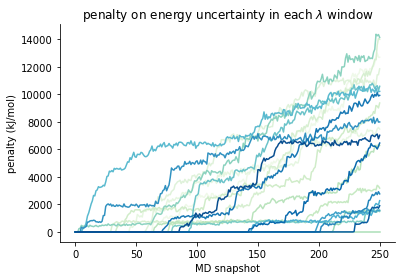

In [173]:
format_ax(plt.subplot(1,1,1))
for lam in raw_energy_dict:
    raw_energies_0 = raw_energy_dict[lam].raw_energies_without_dummy_0
    raw_energies_1 = raw_energy_dict[lam].raw_energies_without_dummy_1
    
    linear_penalty = compute_linear_penalty(raw_energies_0, raw_energies_1, lam)
    
    plt.plot(linear_penalty, c=colors[lam])
#"plt.colorbar()
plt.xlabel('MD snapshot')
plt.ylabel('penalty (kJ/mol)')
plt.title('penalty on energy uncertainty in each $\lambda$ window')
plt.savefig('sampl2mol_penalties.png', dpi=300, bbox_inches='tight')

In [177]:
for lam in sorted(list(last_valid_inds.keys())):
    print('lam={}: usable snapshots: {}'.format(lam, max(0, 10 * last_valid_inds[lam])))

lam=0.0: usable snapshots: 620
lam=0.05: usable snapshots: 2110
lam=0.1: usable snapshots: 830
lam=0.15: usable snapshots: 1440
lam=0.2: usable snapshots: 760
lam=0.25: usable snapshots: 290
lam=0.3: usable snapshots: 40
lam=0.35: usable snapshots: 710
lam=0.4: usable snapshots: 930
lam=0.45: usable snapshots: 1420
lam=0.5: usable snapshots: 790
lam=0.55: usable snapshots: 560
lam=0.6: usable snapshots: 2010
lam=0.65: usable snapshots: 1970
lam=0.7: usable snapshots: 330
lam=0.75: usable snapshots: 0
lam=0.8: usable snapshots: 440
lam=0.85: usable snapshots: 20
lam=0.9: usable snapshots: 2280
lam=0.95: usable snapshots: 50
lam=1.0: usable snapshots: 630


In [86]:
lambdas_with_usable_samples = []
for lam in sorted(list(last_valid_inds.keys())):
    if last_valid_inds[lam] > 5:
        lambdas_with_usable_samples.append(lam)
lambdas_with_usable_samples

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.8,
 0.9,
 1.0]

In [119]:
snapshots = []
N_k = []

max_n_snapshots_per_state = 10

for lam in lambdas_with_usable_samples:
    traj = trajs[lam][5:last_valid_inds[lam]]
    further_thinning = 1
    if len(traj) > max_n_snapshots_per_state:
        further_thinning = int(len(traj) / max_n_snapshots_per_state)
    new_snapshots = list(traj.xyz[::further_thinning] * unit.nanometer)
    snapshots.extend(new_snapshots)
    N_k.append(len(new_snapshots))

N = len(snapshots)
N_k, N

([12, 11, 12, 11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 14, 13, 11, 12], 196)

In [144]:
raw_energies = raw_energy_dict[0.5].raw_energies_without_dummy_0
raw_energies.shape

(251, 348, 8)

In [152]:
def compute_annealed_reduced_u(raw_energies, lambda_value=0.0):
    raw_energies_0 = raw_energies.raw_energies_without_dummy_0
    raw_energies_1 = raw_energies.raw_energies_without_dummy_1
    
    
    total_energies_0 = raw_energies_0.mean(-1).sum(1)
    total_energies_1 = raw_energies_1.mean(-1).sum(1)
    return (hartree_to_kJ_mol) * ((1 - lambda_value) * total_energies_0 + lambda_value * total_energies_1) * unit.kilojoule_per_mole / kT

In [153]:
compute_annealed_reduced_u(raw_energy_dict[0.5], 0.5)

array([-4969.53031026, -4557.08945305, -4425.43801983, -4442.77458719,
       -4454.17847735, -4399.22869532, -4444.72897685, -4493.42057377,
       -4469.81556386, -4457.8334449 , -4422.57218501, -4430.80132002,
       -4373.55122566, -4429.4388299 , -4439.38466242, -4447.66128466,
       -4467.94997969, -4454.36049183, -4466.12052885, -4430.16777724,
       -4418.86106369, -4471.99539443, -4465.0175532 , -4469.82715414,
       -4404.66135294, -4438.12132894, -4435.32626773, -4482.44794458,
       -4494.96819713, -4440.40417875, -4466.82956187, -4483.4553363 ,
       -4525.31092402, -4489.42751916, -4459.2624962 , -4468.16058818,
       -4508.85762161, -4492.63134166, -4499.92781717, -4463.83999101,
       -4493.56863304, -4440.61498751, -4443.48629538, -4493.71616321,
       -4471.00599563, -4458.81350959, -4464.01571235, -4467.46627768,
       -4473.85082112, -4484.85924293, -4510.25942864, -4483.49660018,
       -4519.91672492, -4512.25283889, -4510.9876007 , -4534.70363661,
      

In [120]:
snapshots[0]

Quantity(value=array([[1.2043141 , 0.82193756, 0.93826354],
       [1.0750247 , 0.8750941 , 0.92120725],
       [1.0617447 , 1.0052171 , 0.87106717],
       ...,
       [1.2676312 , 0.5591984 , 1.4049479 ],
       [1.1949848 , 0.55192024, 1.4658102 ],
       [1.345176  , 0.5983258 , 1.4531091 ]], dtype=float32), unit=nanometer)

In [121]:
len(snapshots[-1])

349

In [122]:
energy_function.calculate_energy(snapshots[-1], lambda_value=1.0)

Quantity(value=-23314639.77546569, unit=kilojoule/mole)

In [124]:
# end-point energies
from tqdm import tqdm_notebook as tqdm

lambda0_energies = [energy_function.calculate_energy(x, lambda_value=0.0) for x in tqdm(snapshots)]
lambda1_energies = [energy_function.calculate_energy(x, lambda_value=1.0) for x in tqdm(snapshots)]

lambda0_us = np.array([U/kT for U in lambda0_energies])
lambda1_us = np.array([U/kT for U in lambda1_energies])

def get_u_n(lam=0.0):
    return (1 - lam) * lambda0_us + lam * lambda1_us

In [126]:
u_kn = np.stack([get_u_n(lam) for lam in lambdas_with_usable_samples])

from pymbar import MBAR
mbar = MBAR(u_kn, N_k)

In [212]:
[Delta_f_ij, dDelta_f_ij, Delta_u_ij, dDelta_u_ij, Delta_s_ij, dDelta_s_ij] = mbar.computeEntropyAndEnthalpy()

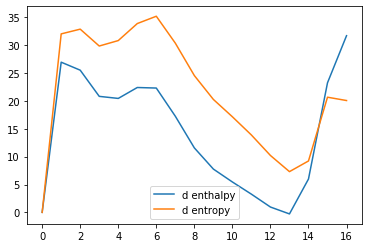

In [217]:
plt.plot(Delta_u_ij[:,0], label='d enthalpy')
plt.plot(Delta_s_ij[:,0], label='d entropy')
plt.legend()

array([ 0.        , 32.02719641, 32.87695608, 29.84977044, 30.82697786,
       33.88110719, 35.19316441, 30.36350573, 24.54728431, 20.26575964,
       17.15206435, 13.8790978 , 10.20654794,  7.31002086,  9.22415393,
       20.66495384, 20.06812347])

In [128]:
DeltaFs, dDeltaFs = mbar.getFreeEnergyDifferences()[:2]

In [138]:
DeltaFs[0,-1], dDeltaFs[0,-1]

(-11.63360873414714, 1.2726293245040554)

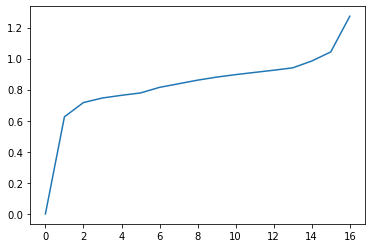

In [139]:
plt.plot(dDeltaFs[0])

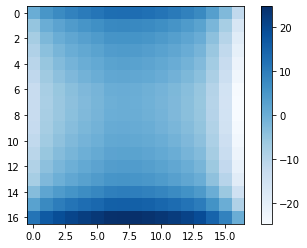

In [129]:
plt.imshow(DeltaFs, cmap='Blues')
plt.colorbar()

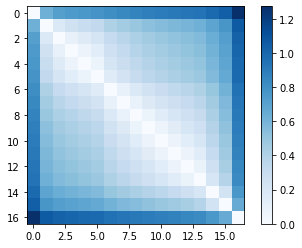

In [130]:
plt.imshow(dDeltaFs, cmap='Blues')
plt.colorbar()

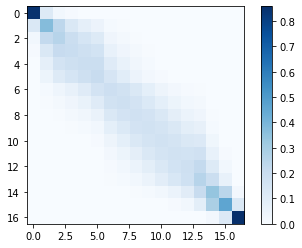

In [159]:
overlap_matrix = mbar.computeOverlap()[2]
plt.imshow(overlap_matrix, cmap='Blues')
plt.colorbar()

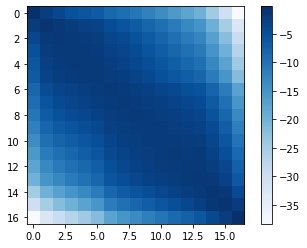

In [161]:
plt.imshow(np.log(overlap_matrix), cmap='Blues')
plt.colorbar()

Text(0, 0.5, 'kcal/mol')

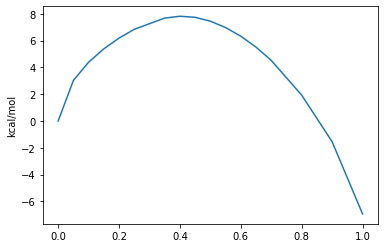

In [132]:
plt.plot(lambdas_with_usable_samples, (mbar.f_k * kT).value_in_unit(unit.kilocalorie_per_mole))
plt.ylabel('kcal/mol')

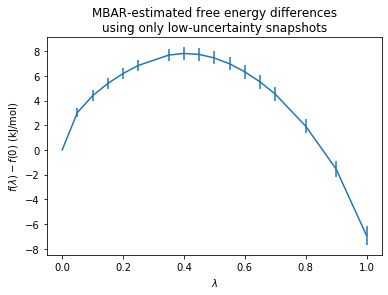

In [182]:
diffs = (DeltaFs[0] * kT).value_in_unit(unit.kilocalorie_per_mole)
uncs = (dDeltaFs[0] * kT).value_in_unit(unit.kilocalorie_per_mole)
plt.errorbar(lambdas_with_usable_samples, diffs, uncs)
plt.xlabel('$\lambda$')
plt.ylabel('$f(\lambda) - f(0)$ (kJ/mol)')
plt.title('MBAR-estimated free energy differences\nusing only low-uncertainty snapshots')
plt.savefig('sampl2mol_result_using_low_uncertainty_snapshots.png', dpi=300, bbox_inches='tight')

In [136]:
(mbar.f_k * kT).value_in_unit(unit.kilocalorie_per_mole)[-1]

-6.9355152648910225

In [134]:
exp_results = pickle.load(open('/Users/joshuafass/Documents/Github/neutromeratio/data/exp_results.pickle', 'rb'))
exp_results['SAMPLmol2']['energy']

-6.1

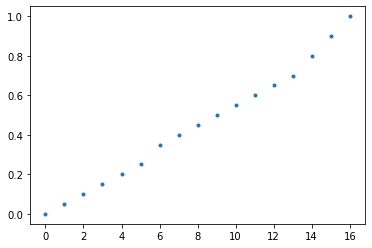

In [87]:
plt.plot(lambdas_with_usable_samples, '.')

(0, 0.10250000000000009)

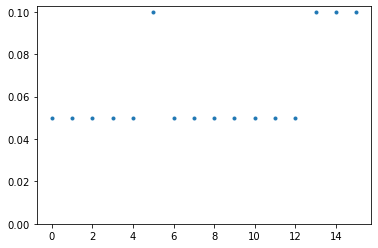

In [89]:
plt.plot(np.diff(lambdas_with_usable_samples), '.')
plt.ylim(0,)

In [78]:
raw_energy_dict[0].raw_energies_without_dummy_0

array([[[-5.37811127e-03, -8.31201393e-03, -6.96197385e-03, ...,
         -1.07257571e-02, -1.25410017e-02, -1.06498403e-02],
        [-1.13445930e-02, -1.29510174e-02, -2.07670312e-03, ...,
         -1.04810987e-02, -6.26449473e-03, -1.10925799e-02],
        [-1.52139552e-02, -1.05062407e-02, -9.28944256e-03, ...,
         -1.35426167e-02, -1.14094820e-02, -1.34817725e-02],
        ...,
        [-1.25988023e-02, -1.73448287e-02, -1.15755191e-02, ...,
         -1.68647803e-02, -1.89614911e-02, -2.35706866e-02],
        [-1.39302993e-02, -1.26885483e-02, -1.70052201e-02, ...,
         -1.28276413e-02, -1.31717836e-02, -1.04554361e-02],
        [-1.52305411e-02, -1.35576380e-02, -1.67776179e-02, ...,
         -1.34194670e-02, -1.24338698e-02, -1.06379855e-02]],

       [[-5.43473847e-03, -8.69811792e-03, -5.74585097e-03, ...,
         -1.25049651e-02, -8.74171592e-03, -1.29312510e-02],
        [-8.38657282e-03, -1.18952300e-02,  1.15304627e-03, ...,
         -5.58915548e-03, -2.43359222e

In [79]:
#from pickle import dump
#with open('raw_energy_dict.pkl', 'wb') as f:
#    dump(raw_energy_dict, f)

In [ ]:
raw_energy_dict[0].raw_energies_without_dummy_0

In [162]:
raw_energies_without_dummy_0.shape

(251, 348, 8)

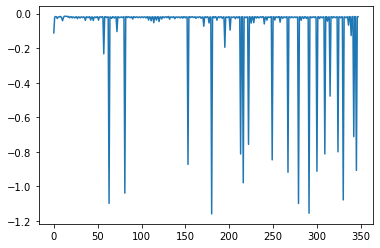

In [163]:
plt.plot(raw_energies_without_dummy_0.min(-1).min(0))

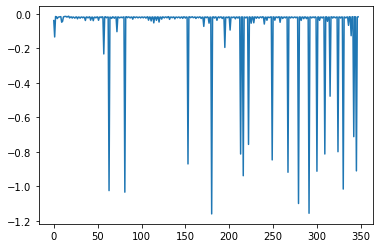

In [164]:
plt.plot(raw_energies_without_dummy_1.min(-1).min(0))

In [125]:
energy_function.model.ensemble_size

8

In [80]:
species_list = list(map(int, mod_species_0[0]))
n_atoms = len(species_list)
n_atoms

348

In [81]:
n_models = 8

In [82]:
mod_aevs_0.shape

torch.Size([251, 348, 384])

In [83]:
from tqdm import tqdm

In [84]:
print('n_snapshots: {}, n_atoms: {}, n_models: {}'.format(n_snapshots, n_atoms, n_models))
raw_energies = np.zeros((n_snapshots, n_atoms, n_models))
for i in tqdm(range(n_atoms)):
    for j in range(n_models):
        raw_energies[:,i,j] = model.neural_networks[j][species_list[i]].forward(mod_aevs_0[:,i,:]).detach().flatten()

  2%|▏         | 7/348 [00:00<00:05, 63.72it/s]

n_snapshots: 251, n_atoms: 348, n_models: 8


100%|██████████| 348/348 [00:04<00:00, 85.21it/s]


In [85]:
raw_energies.shape

(251, 348, 8)

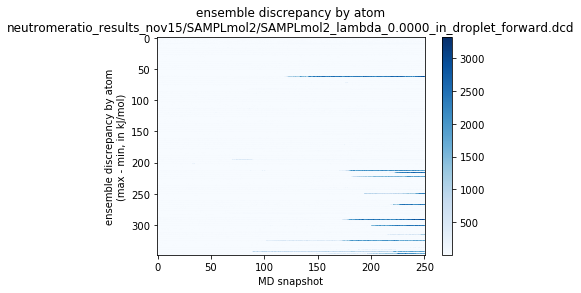

In [86]:
ensemble_discrepancy_kj_mol = (raw_energies.max(-1).T - raw_energies.min(-1).T) * hartree_to_kJ_mol
plt.imshow(ensemble_discrepancy_kj_mol,  cmap='Blues', aspect='auto')
plt.colorbar()
plt.xlabel('MD snapshot')
plt.ylabel('ensemble discrepancy by atom\n(max - min, in kJ/mol)')
plt.title('ensemble discrepancy by atom\n'+dcd)
plt.savefig('ensemble_discrepancy_by_atom_lam={}.png'.format(lam_str), dpi=300, bbox_inches='tight')

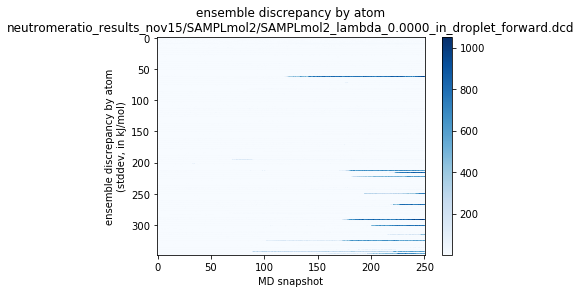

In [87]:
ensemble_discrepancy_kj_mol = (raw_energies.std(-1).T) * hartree_to_kJ_mol
plt.imshow(ensemble_discrepancy_kj_mol,  cmap='Blues', aspect='auto')
plt.colorbar()
plt.xlabel('MD snapshot')
plt.ylabel('ensemble discrepancy by atom\n(stddev, in kJ/mol)')
plt.title('ensemble discrepancy by atom\n'+dcd)
plt.savefig('ensemble_stddev_by_atom_lam={}.png'.format(lam_str), dpi=300, bbox_inches='tight')

In [88]:
bad_inds = np.where(ensemble_discrepancy_kj_mol.max(1) > 400)[0]
bad_inds

array([ 63,  81, 153, 180, 213, 216, 222, 249, 267, 279, 291, 300, 309,
       315, 324, 330, 342, 345])

In [89]:
raw_energies.sum(-1).shape

(251, 348)

In [90]:
bad_inds

array([ 63,  81, 153, 180, 213, 216, 222, 249, 267, 279, 291, 300, 309,
       315, 324, 330, 342, 345])

In [91]:
raw_energies.mean(-1)[0,bad_inds]

array([-0.01812073, -0.01799208, -0.01666472, -0.01664615, -0.01764182,
       -0.01741023, -0.01683288, -0.01754384, -0.01630345, -0.01806612,
       -0.01756463, -0.01658693, -0.01910317, -0.01650269, -0.01666318,
       -0.01710468, -0.01624684, -0.0174908 ])

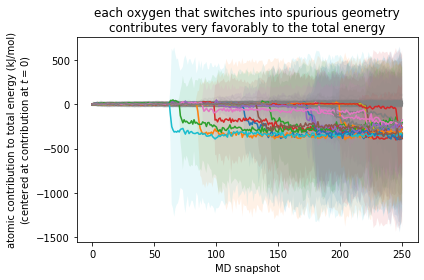

In [224]:
plt.plot(
    (raw_energies.mean(-1) - raw_energies.mean(-1)[0]) * hartree_to_kJ_mol,
c='grey', alpha=0.1)


mean = (raw_energies.mean(-1)[:,bad_inds] - raw_energies.mean(-1)[0,bad_inds]) * hartree_to_kJ_mol
stddev = (hartree_to_kJ_mol * raw_energies).std(-1)[:,bad_inds]
for i in range(len(bad_inds)):
    plt.plot(np.arange(len(raw_energies)), mean[:,i])
    plt.fill_between(np.arange(len(raw_energies)),
                 mean[:,i] - stddev[:,i], mean[:,i] + stddev[:,i], alpha=0.1)


plt.ylabel('atomic contribution to total energy (kJ/mol)\n(centered at contribution at $t=0$)')
plt.xlabel('MD snapshot')

plt.title('each oxygen that switches into spurious geometry\ncontributes very favorably to the total energy')

plt.tight_layout()
plt.savefig('per_atom_energy_contributions_{}_w_uncertainty.png'.format(lam_str), dpi=300, bbox_inches='tight')

In [171]:
def format_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

In [239]:
def plot_energy_contributions(raw_energies, bad_inds, plot_uncertainty_band=True):
    """raw_energies is an array of shape (n_snapshots, n_atoms, n_models), assumed in hartree
    bad_inds is a list of atom indices that we want to color -- all other atoms will be grey
    """
    plt.plot(
        (raw_energies.mean(-1) - raw_energies.mean(-1)[0]) * hartree_to_kJ_mol,
    c='grey', alpha=0.1)


    mean = (raw_energies.mean(-1)[:,bad_inds] - raw_energies.mean(-1)[0,bad_inds]) * hartree_to_kJ_mol
    stddev = (hartree_to_kJ_mol * raw_energies).std(-1)[:,bad_inds]
    for i in range(len(bad_inds)):
        plt.plot(np.arange(len(raw_energies)), mean[:,i])
        if plot_uncertainty_band:
            plt.fill_between(np.arange(len(raw_energies)),
                         mean[:,i] - stddev[:,i], mean[:,i] + stddev[:,i], alpha=0.1)


    plt.ylabel('atomic contribution to total energy (kJ/mol)\n(centered at contribution at $t=0$)')
    plt.xlabel('MD snapshot')
    start_of_sentence = 'each oxygen that switches into spurious geometry'
    end_of_sentence = 'contributes very favorably to the total energy'
    if plot_uncertainty_band:
        end_of_sentence = 'is highly "controversial"'
    plt.title('{}\n{}'.format(start_of_sentence, end_of_sentence))

    plt.tight_layout()
    
def plot_total_uncertainty(raw_energies):
    plt.plot((raw_energies * hartree_to_kJ_mol).sum(1).std(-1))
    plt.xlabel('MD snapshot')
    plt.ylabel('ensemble stddev in total energy (kJ/mol)')
    plt.title('ensemble discrepancy for total energy increases')
    plt.tight_layout()
    
plt.figure(figsize=(16,4))
ax = format_ax(plt.subplot(1,3,1))
plot_energy_contributions(raw_energies, bad_inds, plot_uncertainty_band=False)

ax = format_ax(plt.subplot(1,3,2))
plot_energy_contributions(raw_energies, bad_inds, plot_uncertainty_band=True)

ax = format_ax(plt.subplot(1,3,3))
plot_total_uncertainty(raw_energies)
per_atom_thresh = 0.5 # in kJ/mol
total_thresh = per_atom_thresh * n_atoms
plt.hlines(total_thresh,0,len(raw_energies),linestyles='--',label='n_atoms * ({} kJ/mol)'.format(per_atom_thresh))
plt.yscale('log')
plt.legend()

plt.savefig('per_atom_energy_contributions_{}_w_uncertainty.png'.format(lam_str), dpi=300, bbox_inches='tight')

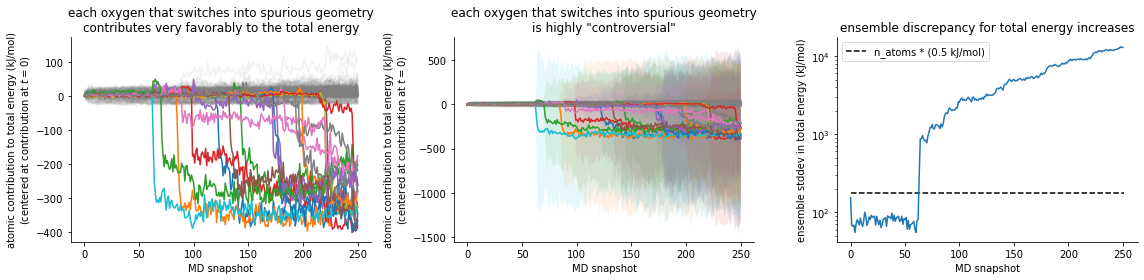

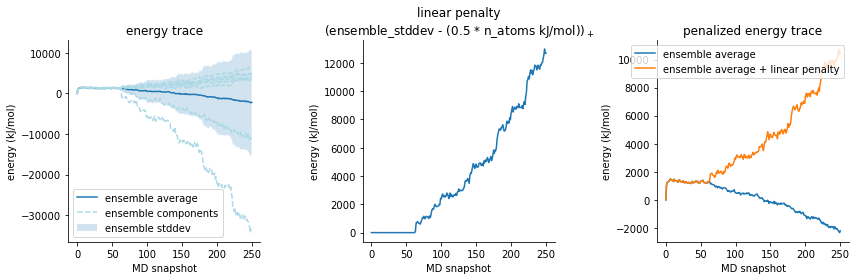

In [283]:
per_atom_thresh = 0.5 # in kJ/mol
total_thresh = per_atom_thresh * n_atoms

total_energies = raw_energies.mean(-1).sum(1) * hartree_to_kJ_mol
offset = total_energies[0]
total_energies -= offset

total_uncertainties = (raw_energies * hartree_to_kJ_mol).sum(1).std(-1)
linear_penalty = np.maximum(0, total_uncertainties - total_thresh)

def add_energy_ax_labels():
    plt.xlabel('MD snapshot')
    plt.ylabel('energy (kJ/mol)')
def remove_legend_duplicates():
    """thank u 2 https://stackoverflow.com/a/36189073"""
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    plt.legend(handles, labels, loc='best')

plt.figure(figsize=(12,4))

# plot total energy without correction
ax = format_ax(plt.subplot(1,3,1))
add_energy_ax_labels()
plt.title('energy trace')
plt.plot(total_energies, label='ensemble average')
plt.fill_between(
    np.arange(len(total_energies)),
    total_energies - total_uncertainties,
    total_energies + total_uncertainties,
    alpha=0.2,
    label='ensemble stddev'
)
plt.plot(raw_energies.sum(1) * hartree_to_kJ_mol - offset,
         color='lightblue',
         linestyle='--', label='ensemble components')
remove_legend_duplicates()
#plt.legend()
# plot correction
ax = format_ax(plt.subplot(1,3,2))
add_energy_ax_labels()
plt.title('linear penalty\n(ensemble_stddev - ({} * n_atoms kJ/mol))$_+$'.format(per_atom_thresh))
plt.plot(linear_penalty)

# plot total energy with correction
ax = format_ax(plt.subplot(1,3,3))
add_energy_ax_labels()
plt.plot(total_energies, label='ensemble average')
plt.plot(total_energies + linear_penalty, label='ensemble average + linear penalty')
plt.legend()
plt.title('penalized energy trace')
plt.tight_layout()

plt.savefig('linear_penalty.png', dpi=300, bbox_inches='tight')

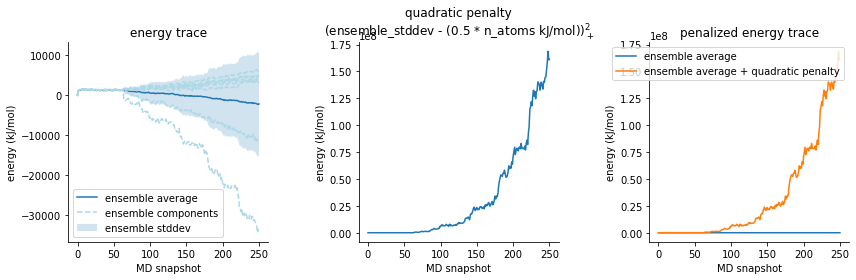

In [284]:
quadratic_penalty = linear_penalty**2

def add_energy_ax_labels():
    plt.xlabel('MD snapshot')
    plt.ylabel('energy (kJ/mol)')
def remove_legend_duplicates():
    """thank u 2 https://stackoverflow.com/a/36189073"""
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    plt.legend(handles, labels, loc='best')

plt.figure(figsize=(12,4))

# plot total energy without correction
ax = format_ax(plt.subplot(1,3,1))
add_energy_ax_labels()
plt.title('energy trace')
plt.plot(total_energies, label='ensemble average')
plt.fill_between(
    np.arange(len(total_energies)),
    total_energies - total_uncertainties,
    total_energies + total_uncertainties,
    alpha=0.2,
    label='ensemble stddev'
)
plt.plot(raw_energies.sum(1) * hartree_to_kJ_mol - offset,
         color='lightblue',
         linestyle='--', label='ensemble components')
remove_legend_duplicates()
#plt.legend()
# plot correction
ax = format_ax(plt.subplot(1,3,2))
add_energy_ax_labels()
plt.title('quadratic penalty\n(ensemble_stddev - ({} * n_atoms kJ/mol))$_+^2$'.format(per_atom_thresh))
plt.plot(quadratic_penalty)

# plot total energy with correction
ax = format_ax(plt.subplot(1,3,3))
add_energy_ax_labels()
plt.plot(total_energies, label='ensemble average')
plt.plot(total_energies + quadratic_penalty, label='ensemble average + quadratic penalty')
plt.legend()
plt.title('penalized energy trace')
plt.tight_layout()

plt.savefig('quadratic_penalty.png', dpi=300, bbox_inches='tight')

(0, 2000)

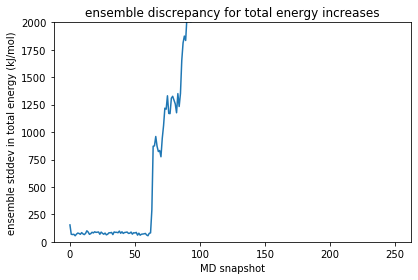

In [243]:
plot_total_uncertainty(raw_energies)
plt.ylim(0,2000)

<function matplotlib.pyplot.savefig(*args, **kwargs)>

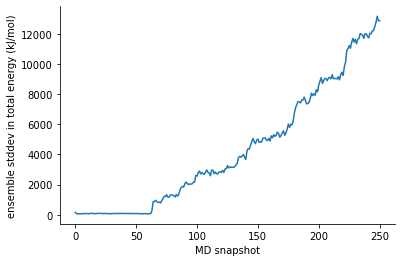

In [230]:

ax = plt.subplot(1,1,1)

plt.plot((raw_energies * hartree_to_kJ_mol).sum(1).std(-1))
plt.xlabel('MD snapshot')
plt.ylabel('ensemble stddev in total energy (kJ/mol)')
plt.savefig()

In [93]:
residues = list(traj.top.residues)
residues

[UNL1,
 HOH2,
 HOH3,
 HOH4,
 HOH5,
 HOH6,
 HOH7,
 HOH8,
 HOH9,
 HOH10,
 HOH11,
 HOH12,
 HOH13,
 HOH14,
 HOH15,
 HOH16,
 HOH17,
 HOH18,
 HOH19,
 HOH20,
 HOH21,
 HOH22,
 HOH23,
 HOH24,
 HOH25,
 HOH26,
 HOH27,
 HOH28,
 HOH29,
 HOH30,
 HOH31,
 HOH32,
 HOH33,
 HOH34,
 HOH35,
 HOH36,
 HOH37,
 HOH38,
 HOH39,
 HOH40,
 HOH41,
 HOH42,
 HOH43,
 HOH44,
 HOH45,
 HOH46,
 HOH47,
 HOH48,
 HOH49,
 HOH50,
 HOH51,
 HOH52,
 HOH53,
 HOH54,
 HOH55,
 HOH56,
 HOH57,
 HOH58,
 HOH59,
 HOH60,
 HOH61,
 HOH62,
 HOH63,
 HOH64,
 HOH65,
 HOH66,
 HOH67,
 HOH68,
 HOH69,
 HOH70,
 HOH71,
 HOH72,
 HOH73,
 HOH74,
 HOH75,
 HOH76,
 HOH77,
 HOH78,
 HOH79,
 HOH80,
 HOH81,
 HOH82,
 HOH83,
 HOH84,
 HOH85,
 HOH86,
 HOH87,
 HOH88,
 HOH89,
 HOH90,
 HOH91,
 HOH92,
 HOH93,
 HOH94,
 HOH95,
 HOH96,
 HOH97,
 HOH98,
 HOH99,
 HOH100,
 HOH101,
 HOH102,
 HOH103,
 HOH104,
 HOH105,
 HOH106,
 HOH107,
 HOH108,
 HOH109,
 HOH110,
 HOH111]

In [94]:
residue = residues[1]
residue

HOH2

In [95]:
[a.index for a in residue.atoms]

[19, 20, 21]

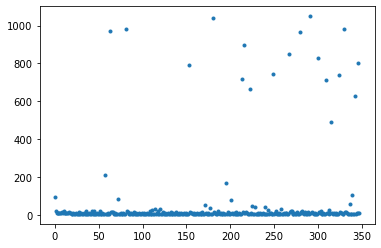

In [96]:
plt.plot(ensemble_discrepancy_kj_mol.max(1), '.')

In [165]:
# traj is an mdtraj.Trajectory, assume all residues in traj after first are water
import mdtraj as md
all_residues = list(traj.top.residues)
water_residues = all_residues[1:]
angle_indices = []
bad_residue_inds = []
bad_residues = []

for i, residue in enumerate(water_residues):
    O,H1,H2 = [a.index for a in residue.atoms]
    if O + 2 in bad_inds:
        bad_residue_inds.append(i)
        bad_residues.append(residue)
    angle_indices.append((H1,O,H2))
angle_indices = np.array(angle_indices)
angles = md.compute_angles(traj, angle_indices=angle_indices)
angles.shape

(2501, 110)

In [167]:
angle_indices.shape

(110, 3)

In [170]:
b_factors = np.zeros(traj.xyz.shape[:2])
for ind, (H1, O, H2) in enumerate(angle_indices):
    b_factors[:,O] = angles[:,ind]

In [171]:
b_factors

array([[0.        , 0.        , 0.        , ..., 1.8905865 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.847018  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.9706291 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 2.19547558, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.17560911, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.16026473, 0.        ,
        0.        ]])

In [172]:
b_factors.shape

(2501, 349)

In [98]:
bad_residue_inds

[14, 20, 44, 53, 64, 65, 67, 76, 82, 86, 90, 93, 96, 98, 101, 103, 107, 108]

In [99]:
list(residue.atoms)

[HOH111-O, HOH111-H1, HOH111-H2]

In [100]:
angles.min(0).shape

(110,)

In [101]:
residues[1+bad_residue_ind]

NameError: name 'bad_residue_ind' is not defined

In [102]:
len(angles)

2501

In [103]:
bad_inds

array([ 63,  81, 153, 180, 213, 216, 222, 249, 267, 279, 291, 300, 309,
       315, 324, 330, 342, 345])

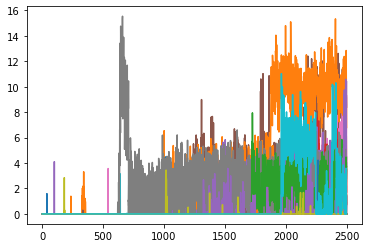

In [203]:
angles_in_degrees = (angles * 180 / np.pi)
exceed_threshold = np.maximum(angles_in_degrees - 125, 0)
plt.plot(exceed_threshold);

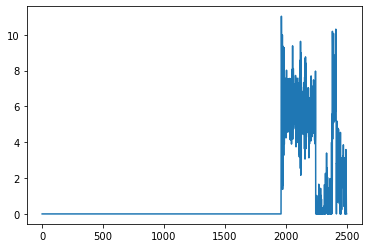

In [204]:
plt.plot(exceed_threshold[:,i]);

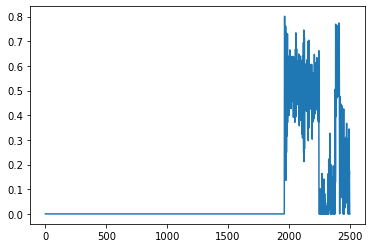

In [205]:
plt.plot(np.tanh(exceed_threshold[:,i] / 10));

In [219]:
bfactors_by_angle = np.tanh(exceed_threshold / 10)

bfactors_by_atom = np.zeros(traj.xyz.shape[:2])
for ind, (H1, O, H2) in enumerate(angle_indices):
    bfactors_by_atom[:,O] = bfactors_by_angle[:,ind]
    bfactors_by_atom[:,H1] = bfactors_by_angle[:,ind]
    bfactors_by_atom[:,H2] = bfactors_by_angle[:,ind]

In [220]:
bfactors_by_atom.max()

0.9144934415817261

In [223]:
thin = 5
filename = 'lam=0_with_bfactors.pdb'
traj[::5].save_pdb(filename, bfactors=bfactors_by_atom[::thin].max(0))

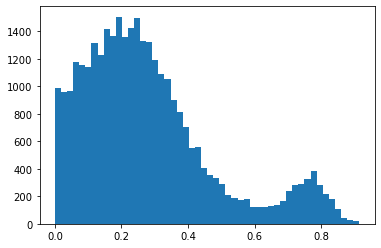

In [222]:
plt.hist(bfactors_by_atom.flatten()[bfactors_by_atom.flatten()>0], bins=50);

In [208]:
bfactors.shape, traj.xyz.shape

((2501, 110), (2501, 349, 3))

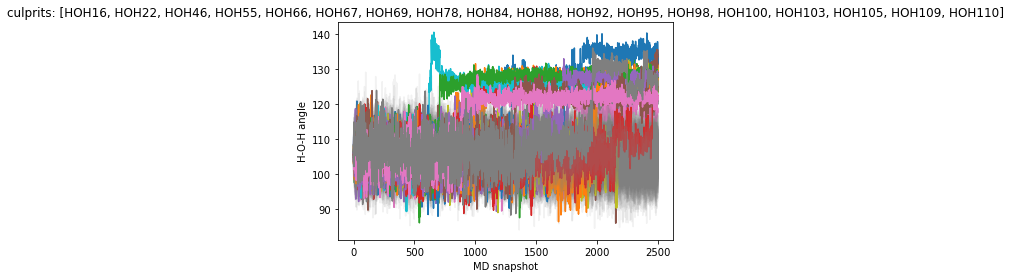

In [105]:
for i in range(len(angles.T)):
    if i - 1 in bad_residue_inds:
        #color = 'red'
        alpha = 1.0
        plt.plot(angles[:,i] * 180 / np.pi, alpha=alpha);
    else:
        #color = 'grey'
        alpha =0.1
        plt.plot(angles[:,i] * 180 / np.pi, color='grey', alpha=alpha);
plt.xlabel('MD snapshot')
plt.ylabel('H-O-H angle')
plt.title('culprits: ' + str(bad_residues))
plt.savefig('weird_water_angles_lam={}.png'.format(lam_str), dpi=300, bbox_inches='tight')

In [106]:
traj.superpose(traj[-1])

<mdtraj.Trajectory with 2501 frames, 349 atoms, 111 residues, without unitcells at 0x1416ad9e8>

In [107]:
traj[::5].save_pdb('sampl2_droplet_lam=0.pdb')

In [55]:
distances_to_ligand = md.compute_distances(traj, [[bad_inds[0] - 2,i] for i in [a.index for a in all_residues[0].atoms]])

In [56]:
distances_to_ligand.shape

(2501, 19)

Text(0.5, 1.0, 'distance(29, ligand_atoms[i])')

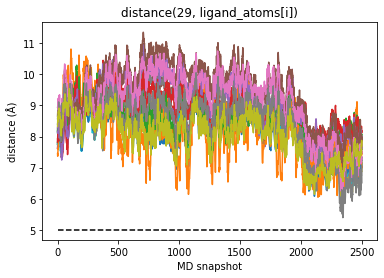

In [57]:
plt.plot(distances_to_ligand * 10)
plt.hlines(5,0,len(distances_to_ligand), linestyles='--')
plt.ylabel('distance (Å)')
plt.xlabel('MD snapshot')
plt.title('distance({}, ligand_atoms[i])'.format(bad_inds[0] + 2))

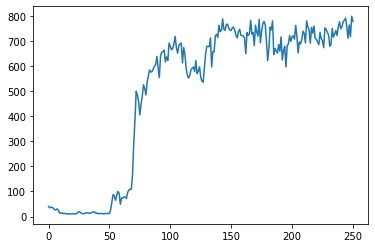

In [357]:
plt.plot(ensemble_discrepancy_kj_mol.max(0))

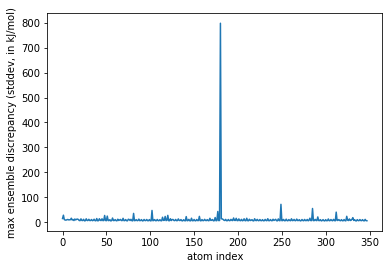

In [331]:
plt.plot(ensemble_discrepancy_kj_mol.max(1))
plt.xlabel('atom index')
plt.ylabel('max ensemble discrepancy (stddev, in kJ/mol)')
plt.savefig('max_ensemble_discrepancies.png', dpi=300, bbox_inches='tight')

In [345]:
traj.save_pdb('bad_traj.pdb')

In [352]:
traj.atom_slice([180])

<mdtraj.Trajectory with 251 frames, 1 atoms, 1 residues, without unitcells at 0x14932aa90>

In [356]:
traj.top.atom(181)

HOH56-O

In [351]:
traj.xyz.shape

(251, 349, 3)

In [310]:
bad_atom_index = np.argmax(ensemble_discrepancy_kj_mol.max(1))
bad_atom_index

180

In [311]:
species_list[bad_atom_index]

3

In [317]:
worst_atom_indices = np.argsort(-ensemble_discrepancy_kj_mol.max(1))

In [332]:
[species_list[i] for i in worst_atom_indices[:20]]

[3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3]

In [334]:
ensemble_discrepancy_kj_mol.max(1)[worst_atom_indices[:20]]

array([798.05771857,  71.5153601 ,  54.90454227,  47.05775564,
        42.82920201,  40.23739813,  35.13424959,  27.96433331,
        27.32275702,  26.90647368,  24.28476502,  23.52566103,
        23.17415453,  22.94968683,  22.32837851,  20.99123844,
        19.68721698,  18.59636469,  18.06988945,  16.71586292])

In [346]:
set(species_list)

{0, 1, 2, 3}

In [348]:
color_dict = {0: 'lightgrey', 1: 'grey', 2: 'blue', 3: 'red'}
colors = [color_dict[s] for s in species_list]

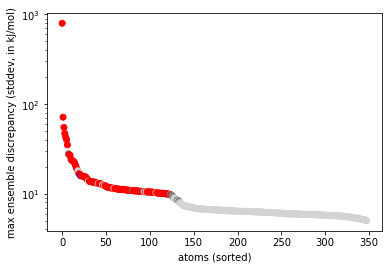

In [350]:
plt.scatter(
    np.arange(len(colors)),
    sorted(ensemble_discrepancy_kj_mol.max(1))[::-1],
    c=[colors[i] for i in worst_atom_indices])
plt.yscale('log')
plt.xlabel('atoms (sorted)')
plt.ylabel('max ensemble discrepancy (stddev, in kJ/mol)')
plt.savefig('max_ensemble_discrepancies_sorted.png', dpi=300, bbox_inches='tight')

In [339]:
bad_atom_index

180

In [340]:
mod_coordinates_0.shape, dummy_atom_0

(torch.Size([251, 348, 3]), 18)

In [291]:
ensemble_discrepancy_kj_mol.shape

(348, 251)

In [292]:
from sklearn.decomposition import PCA


In [299]:
energy_stddevs = (raw_energies * hartree_to_kJ_mol).sum(1).std(1)
energy_stddevs.shape

(251,)

In [300]:
max_energies = raw_energies.max(-1).sum(1)
min_energies = raw_energies.min(-1).sum(1)
energy_discrepancies = hartree_to_kJ_mol* (max_energies - min_energies)
energy_discrepancies.shape

(251,)

In [301]:
raw_energies.shape

(251, 348, 8)

In [302]:
np.save('raw_energies_in_hartree', raw_energies)

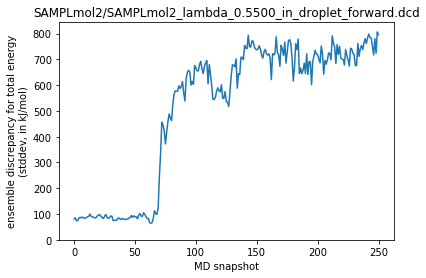

In [304]:
plt.title(dcd)
plt.plot(energy_stddevs )
plt.ylabel('ensemble discrepancy for total energy\n(stddev, in kJ/mol)')
plt.xlabel('MD snapshot')
plt.ylim(0,)
plt.savefig('total_energy_stddev.png', dpi=300, bbox_inches='tight')

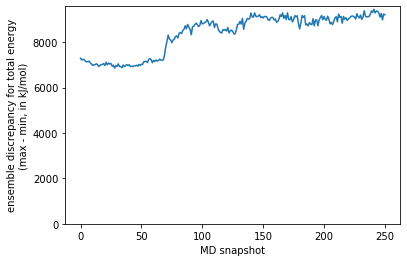

In [297]:

plt.plot(energy_discrepancies)
plt.ylabel('ensemble discrepancy for total energy\n(max - min, in kJ/mol)')
plt.xlabel('MD snapshot')
plt.ylim(0,)
plt.savefig('total_energy_ensemble_discrepancy.png', dpi=300, bbox_inches='tight')

In [250]:
max_energies[0] - min_energies[0]

2.8202054919674993

In [252]:
raw_energies[0].sum(1).mean()

-0.10900208714482343

In [ ]:
raw_energies

In [247]:
(raw_energies * hartree_to_kJ_mol).sum(1).shape

(251, 8)

In [239]:
raw_energies.shape

(251, 348, 8)

In [241]:
raw_energ

NameError: name 'raw_energ' is not defined

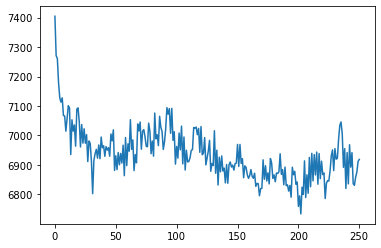

In [193]:
plt.plot((max_energies - min_energies) * hartree_to_kJ_mol)

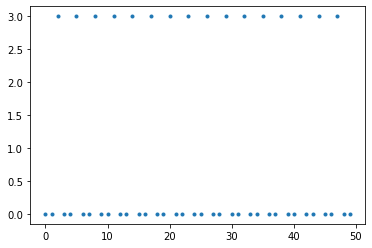

In [187]:
plt.plot(species_list[-50:], '.')

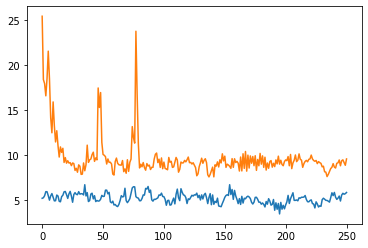

In [242]:
for i in range(2):
    plt.plot((hartree_to_kJ_mol * raw_energies[:,110+i]).std(-1))

In [184]:
species_list[110:112]

[0, 3]

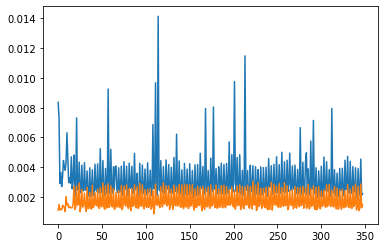

In [168]:
plt.plot(raw_energies.std(-1).max(0))
plt.plot(raw_energies.std(-1).min(0))

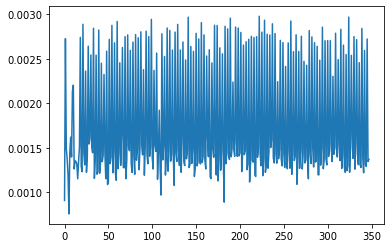

In [144]:
species_list

[3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,


In [ ]:
E_0_unshifted, _ = self.neural_networks((mod_species_0, mod_aevs_0))

In [2]:
    def forward(self, species_coordinates):
        # for now only allow one alchemical atom

        # species, AEVs of fully interacting system
        species, coordinates, lam = species_coordinates
        # NOTE: I am not happy about this - the order at which 
        # the dummy atoms are set in alchemical_atoms determines 
        # what is real and what is dummy at lambda 1 - that seems awefully error prone
        dummy_atom_0 = self.alchemical_atoms[0]
        dummy_atom_1 = self.alchemical_atoms[1]

        # neural net output given these AEVs
        mod_species_0 = torch.cat((species[:, :dummy_atom_0],  species[:, dummy_atom_0+1:]), dim=1)
        mod_coordinates_0 = torch.cat((coordinates[:, :dummy_atom_0],  coordinates[:, dummy_atom_0+1:]), dim=1) 
        _, mod_aevs_0 = self.aev_computer((mod_species_0, mod_coordinates_0))
        # neural net output given these modified AEVs
        E_0_unshifted, _ = self.neural_networks((mod_species_0, mod_aevs_0))
        _, E_0 = self.energy_shifter((mod_species_0, E_0_unshifted))
        
        # neural net output given these AEVs
        mod_species_1 = torch.cat((species[:, :dummy_atom_1],  species[:, dummy_atom_1+1:]), dim=1)
        mod_coordinates_1 = torch.cat((coordinates[:, :dummy_atom_1],  coordinates[:, dummy_atom_1+1:]), dim=1) 
        _, mod_aevs_1 = self.aev_computer((mod_species_1, mod_coordinates_1))
        # neural net output given these modified AEVs
        E_1_unshifted, _ = self.neural_networks((mod_species_1, mod_aevs_1))
        _, E_1 = self.energy_shifter((mod_species_1, E_1_unshifted))

        E = (lam * E_1) + ((1 - lam) * E_0)
        return species, E

In [217]:
import torchani
import torch
import numpy as np

model = torchani.models.ANI1ccx()
coordinates = torch.tensor([[[0.03192167, 0.00638559, 0.01301679],
                             [-0.83140486, 0.39370209, -0.26395324],
                             [-0.66518241, -0.84461308, 0.20759389],
                             [0.45554739, 0.54289633, 0.81170881],
                             [0.66091919, -0.16799635, -0.91037834]]])
species = model.species_to_tensor('CHHHH').unsqueeze(0)
species_list = list(map(int, species.flatten()))
n_atoms = len(species.flatten())
n_models = model.ensemble_size
energy_offset = model.energy_shifter.sae(species)
per_atom_offset = (energy_offset / n_atoms)

(species, aev) = model.aev_computer.forward((species, coordinates))

print('n_atoms: {}, n_models: {}'.format(n_atoms, n_models))
raw_energies = np.zeros((n_atoms, n_models))
for i in range(n_atoms):
    for j in range(n_models):
        raw_energies[i,j] = model.neural_networks[j][species_list[i]].forward(aev[:,i,:])
energies = raw_energies + float(per_atom_offset)
print('energies without offset:', raw_energies)
print('energies with offset:', energies)
print('energies.mean(1).sum(): {:.6f}'.format(energies.mean(1).sum()))
print('model.forward(species_coordinates): {:.6f}'.format(float(model.forward((species, coordinates))[1].detach())))

n_atoms: 5, n_models: 8
energies without offset: [[ 0.00213959  0.0137589   0.01675431  0.00514815  0.00913496 -0.00387512
   0.02238298  0.00610942]
 [ 0.00792932  0.00852969  0.00701754  0.00882281  0.00737028  0.01358964
   0.00423281  0.00803024]
 [ 0.00256213  0.00269207  0.00087607  0.00092808  0.00061576  0.00428582
  -0.00092739  0.00247494]
 [-0.00420568 -0.00728451 -0.00863859 -0.00473478 -0.00579633 -0.00233379
  -0.008442   -0.00470223]
 [-0.00310021 -0.00566239 -0.0063699  -0.00450698 -0.00493488 -0.0011468
  -0.00699802 -0.00382177]]
energies with offset: [[-8.08468213 -8.07306282 -8.07006741 -8.08167357 -8.07768676 -8.09069683
  -8.06443873 -8.0807123 ]
 [-8.0788924  -8.07829203 -8.07980418 -8.0779989  -8.07945144 -8.07323207
  -8.08258891 -8.07879148]
 [-8.08425958 -8.08412965 -8.08594565 -8.08589364 -8.08620596 -8.08253589
  -8.08774911 -8.08434678]
 [-8.0910274  -8.09410623 -8.09546031 -8.0915565  -8.09261805 -8.08915551
  -8.09526372 -8.09152395]
 [-8.08992193 -8.092

In [218]:
energies.shape

(5, 8)

In [220]:
(energies * hartree_to_kJ_mol).std(1)

array([20.71276529,  6.39562757,  3.97818553,  5.42288263,  4.63232385])

In [219]:
(energies.max(1) - energies.min(1)) * hartree_to_kJ_mol

array([68.94063158, 24.56636671, 13.68730392, 16.55324901, 15.36237688])

In [50]:
coordinate_batch.shape

torch.Size([10, 5, 3])

In [79]:

n_snapshots = 1000
coordinate_batch = torch.stack([coordinates[0]] * n_snapshots) # dummy: n_snapshots copies of one configuration
species_batch = torch.stack([species[0]] * n_snapshots)

In [80]:
%%time
(species_batch, aev) = model.aev_computer.forward((species_batch, coordinate_batch))

print('n_snapshots: {}, n_atoms: {}, n_models: {}'.format(n_snapshots, n_atoms, n_models))
raw_energies = np.zeros((n_snapshots, n_atoms, n_models))
for i in range(n_atoms):
    for j in range(n_models):
        raw_energies[:,i,j] = model.neural_networks[j][species_list[i]].forward(aev[:,i,:]).detach().flatten()
energies = raw_energies + float(per_atom_offset)

n_snapshots: 1000, n_atoms: 5, n_models: 8
CPU times: user 1.32 s, sys: 30.6 ms, total: 1.35 s
Wall time: 343 ms


In [60]:
print('energies without offset:', raw_energies)
print('energies with offset:', energies)
print('energies.mean(1).sum(): {:.6f}'.format(energies.mean(1).sum()))
print('model.forward(species_coordinates): {:.6f}'.format(float(model.forward((species, coordinates))[1].detach())))

energies without offset: [[[ 0.00213958  0.0137589   0.01675431  0.00514815  0.00913496
   -0.00387512  0.02238298  0.00610942]
  [ 0.00792932  0.00852969  0.00701754  0.00882282  0.00737028
    0.01358964  0.00423281  0.00803024]
  [ 0.00256213  0.00269207  0.00087607  0.00092808  0.00061576
    0.00428582 -0.0009274   0.00247494]
  [-0.00420569 -0.00728451 -0.00863859 -0.00473478 -0.00579633
   -0.00233378 -0.008442   -0.00470223]
  [-0.00310021 -0.00566239 -0.0063699  -0.00450698 -0.00493488
   -0.0011468  -0.00699802 -0.00382178]]

 [[ 0.00213959  0.01375889  0.0167543   0.00514815  0.00913496
   -0.00387513  0.02238298  0.00610942]
  [ 0.00792932  0.00852969  0.00701754  0.00882282  0.00737027
    0.01358964  0.00423281  0.00803024]
  [ 0.00256213  0.00269207  0.00087608  0.00092808  0.00061576
    0.00428582 -0.0009274   0.00247494]
  [-0.00420569 -0.00728451 -0.00863859 -0.00473478 -0.00579633
   -0.00233378 -0.008442   -0.00470223]
  [-0.0031002  -0.00566239 -0.0063699  -0.0045

In [39]:
coordinates.shape

torch.Size([1, 5, 3])

In [48]:

coordinate_batch.shape

torch.Size([10, 5, 3])

In [22]:
energy_shifter = model.energy_shifter
energy_shifter

EnergyShifter()

(-40.425620574687585, -40.425621032714844)

In [26]:
energies.sum(1)

(5,)

In [24]:
model.energy_shifter.

SyntaxError: invalid syntax (<ipython-input-24-54f839e242cb>, line 1)

In [9]:
model.forward((species, coordinates))

(tensor([[1, 0, 0, 0, 0]]), tensor([-40.4256], grad_fn=<AddBackward0>))

(tensor([[1, 0, 0, 0, 0]]), tensor([-40.4256], grad_fn=<AddBackward0>))

In [16]:
aev_computer = model.aev_computer

In [27]:

species_aev = (species, aev)

In [76]:

species_list

[1, 0, 0, 0, 0]

(5, 8)

In [58]:
model.neural_networks[0].forward(species_aev)

(tensor([[1, 0, 0, 0, 0]]), tensor([0.0053], grad_fn=<SumBackward1>))

In [59]:

type(species_list[0])

int

In [60]:
np_species[i]

1

In [61]:
aev.shape

torch.Size([1, 5, 384])

In [62]:
i = 1
aev[:,i,:].shape

torch.Size([1, 384])

In [64]:
energies

array([[ 0.00213959,  0.0137589 ,  0.01675431,  0.00514815,  0.00913496,
        -0.00387512,  0.02238298,  0.00610942],
       [ 0.00792932,  0.00852969,  0.00701754,  0.00882281,  0.00737028,
         0.01358964,  0.00423281,  0.00803024],
       [ 0.00256213,  0.00269207,  0.00087607,  0.00092808,  0.00061576,
         0.00428582, -0.00092739,  0.00247494],
       [-0.00420568, -0.00728451, -0.00863859, -0.00473478, -0.00579633,
        -0.00233379, -0.008442  , -0.00470223],
       [-0.00310021, -0.00566239, -0.0063699 , -0.00450698, -0.00493488,
        -0.0011468 , -0.00699802, -0.00382177]])

In [68]:
energies.sum(1)

array([ 0.07155318,  0.06552233,  0.01350748, -0.04613792, -0.03654095])

In [69]:
energies.std(1)

array([0.00788908, 0.00243597, 0.00151521, 0.00206547, 0.00176436])

In [52]:
energies.shape

(1, 8)

In [34]:
int(species.flatten()[0])

1

In [26]:
model.neural_networks[0][0]()

Sequential(
  (0): Linear(in_features=384, out_features=160, bias=True)
  (1): CELU(alpha=0.1)
  (2): Linear(in_features=160, out_features=128, bias=True)
  (3): CELU(alpha=0.1)
  (4): Linear(in_features=128, out_features=96, bias=True)
  (5): CELU(alpha=0.1)
  (6): Linear(in_features=96, out_features=1, bias=True)
)

In [9]:
help(model.neural_networks[0])

Help on ANIModel in module torchani.nn object:

class ANIModel(torch.nn.modules.container.ModuleList)
 |  ANI model that compute properties from species and AEVs.
 |  
 |  Different atom types might have different modules, when computing
 |  properties, for each atom, the module for its corresponding atom type will
 |  be applied to its AEV, after that, outputs of modules will be reduced along
 |  different atoms to obtain molecular properties.
 |  
 |  Arguments:
 |      modules (:class:`collections.abc.Sequence`): Modules for each atom
 |          types. Atom types are distinguished by their order in
 |          :attr:`modules`, which means, for example ``modules[i]`` must be
 |          the module for atom type ``i``. Different atom types can share a
 |          module by putting the same reference in :attr:`modules`.
 |      reducer (:class:`collections.abc.Callable`): The callable that reduce
 |          atomic outputs into molecular outputs. It must have signature
 |          ``(